# Aligning GPT-2 to Generate Positive Content using Reinforcement Learning with Human Feedback RLHF) and Proximal Policy Optimization (PPO)

## What on earth is RLHF?

Fine-tuning LLMs are great but you often do not have control on the way the model behaves in terms of generating respones. This is where the aspect of **alignment** to human behavior, choices and preferences come in. Without the LLM being aligned to human preferences, you can expect more hallucinations, toxicity, undesired responses.

The authors of the seminal work **[InstructGPT](https://arxiv.org/pdf/2203.02155)** basically focused on this aspect of aligning the language models to human feedback (hence the name!). 

![](https://i.imgur.com/tq6p6zr.png)

Their work showcased how we can further fine-tune such models in a supervised way leverage human feedback and reinforcement learning to align them.

## Key Concepts:

- **Reinforcement Learning (RL)**: A machine learning paradigm where an agent learns to make decisions by performing actions and receiving _rewards or penalties_ .

- **Human Feedback**: Evaluations provided by humans that guide the learning process, ensuring the model's outputs align with human expectations and preferences.

## Use-Case: Use RLHF to Generate Positive Reviews with GPT-2

Reinforcement Learning with Human Feedback (RLHF) can be explained using the steps illustrated below. 

We'll walk through the process of making GPT-2 generate positive movie reviews.


## 1. Rollout - Standard Generation Process during training \ fine-tuning

- **Query:** You start with an incomplete movie review, for example, "This movie is."
- **Language Model (LM):** GPT-2 takes this input and generates a continuation, such as "really great!"
- **Response:** The generated continuation ("really great!") is what GPT-2 suggests as the completion of the review.

## 2. Evaluation
- **Query + Response:** The completed sentence, "This movie is really great!" is then evaluated.
- **Reward Model:** A separate model, called the reward model, assesses the quality of the response. It might be a classifier (like our BERT classifier), a set of rules, or even manual human feedback that judges whether the review is positive and well-formed.
- **Reward:** The reward model assigns a numerical score (reward) to the response based on how well it meets the desired criteria (in this case, being a positive review can get a high positive score >3 and negative review can get a low score < 1).

## 3. Optimization
- **Comparison with a Reference Model:** The GPT-2 model (model being fine-tuned and aligned) that generated the response is compared to a baseline or reference model, which can be an earlier, unoptimized version of GPT-2.
- **Log-Probabilities:** The likelihood (log-probabilities) of the generated response is calculated for both the active and reference models.
- **KL-Divergence (KL-div):** The difference between these probabilities (how much the active model's behavior deviates from the reference) is measured using KL-divergence.
- **PPO (Proximal Policy Optimization):** This is an algorithm that uses the reward and the difference in log-probabilities to adjust the model's parameters. The goal is to improve the model so it generates responses that receive higher rewards more consistently.
- **Final Update:** The model is optimized using policy gradients, balancing the reward and the deviation from the reference model to make GPT-2 better at generating positive reviews.

## Summary
In summary, RLHF for generating positive reviews involves having GPT-2 generate a review, evaluating how positive and well-formed the review is, and then fine-tuning GPT-2 based on this evaluation to improve future reviews. The process is iterative, with continuous adjustments to make the model produce better and more aligned responses over time.


<div style="text-align: center">
<img src='https://i.imgur.com/FfoswhJ.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


In this notebook we fine-tune GPT2 (small) to generate positive movie reviews based on the IMDB dataset. The model gets the start of a real review and is tasked to produce positive continuations. To reward positive continuations we use a BERT classifier to analyse the sentiment of the produced sentences and use the classifier's outputs as rewards signals for PPO training.

## What is PPO?

PPO, or **Proximal Policy Optimization**, is a type of reinforcement learning algorithm that helps a model (like GPT-2) learn better behaviors by making small, controlled updates to its policy. In this context, "policy" refers to the model's strategy for generating responses to inputs.

## How PPO Works in Simple Terms:

1. **Start with a Policy:**
   - Imagine the model has a set of rules or strategies it follows to generate text. This set of rules is called its "policy." Initially, the model uses a certain policy to decide how to respond to inputs. The model starts with an initial policy, based on how it was originally trained usually for LLMs

![](https://i.imgur.com/lTaMTmC.png)

2. **Evaluate the Policy:**
   - The model's current policy generates some responses to given inputs, and these responses are evaluated using the reward model. This evaluation tells us how good or bad the responses are (i.e., how well they match what we want, such as generating positive reviews).

3. **Calculate the Advantage:**
   - PPO compares how much better or worse the new policy (after generating a response) is compared to an older, reference policy. This comparison is called the "advantage." If the new policy is better (higher reward), that’s positive; if it's worse, that’s negative.

4. **Make Small Adjustments:**
   - Instead of making big changes to the policy (which might make the model behave unpredictably), PPO makes small, safe adjustments. It ensures that the updates are "proximal" or close to the previous policy, meaning the model doesn't stray too far from what it already knows.
   - This is done by using a technique called **clipping**. Clipping limits how much the policy can change in one update, preventing drastic changes that could lead to poor performance.

5. **Balance Exploration and Exploitation:**
   - PPO balances between two things: 
     - **Exploration** (trying new ways of generating responses) and 
     - **Exploitation** (sticking with what is already known to work well).
   - By carefully controlling updates, PPO allows the model to gradually improve its policy without making risky or unstable changes.

6. **Iterate:**
   - This process of making small updates, evaluating, and adjusting is repeated many times. Over time, the model’s policy becomes more and more refined, leading to better performance (in this case, generating more positive and higher-quality reviews).

## Why PPO is Effective:

- **Stability:** By making only small, controlled changes, PPO helps ensure that the model's learning process remains stable. It avoids the wild swings in behavior that can happen with larger updates.
- **Efficiency:** PPO is computationally efficient, meaning it can improve the model’s performance without needing excessive computational resources.

## In Summary:

PPO helps GPT-2 (or any other model) learn to generate better responses by carefully adjusting its strategy based on the rewards it receives. It makes sure the model improves steadily and safely, without making any sudden, drastic changes that could lead to poor performance.


You can see that we load simple GPT-2 pretrained model, however here is where you can take a SFT fine-tuned LLM also.

## Load data and models

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [1]:
from trl import AutoModelForCausalLMWithValueHead
from transformers import AutoTokenizer

sft_model_name = 'openai-community/gpt2'
sft_model = AutoModelForCausalLMWithValueHead.from_pretrained(sft_model_name,
                                                              cache_dir="./sft",
                                                              device_map='cuda')
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(sft_model_name,
                                                              cache_dir="./ref",
                                                              device_map='cuda')
tokenizer = AutoTokenizer.from_pretrained(sft_model_name)

tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
from transformers import pipeline

sft_model_pipe = pipeline("text-generation",
                          model='openai-community/gpt2',
                          device_map='cuda',
                          do_sample=True,
                          temperature=0.8,
                          max_new_tokens=50)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
sft_model_pipe('Did not expect this movie',
               eos_token_id=tokenizer.eos_token_id,
               pad_token_id=tokenizer.eos_token_id,)

[{'generated_text': "Did not expect this movie to be anything like my previous movies. It wasn't fun and it wasn't fun in the way I expected. The reason I want to make a movie about the past is so I can make a movie about the future, and maybe those two things"}]

### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 250 characters and < 550 characters (just to train faster). 

Then we tokenize each text and cut it to random size with the `LengthSampler`.

In [9]:
from datasets import load_dataset

ds = load_dataset('imdb', split="train")
ds = ds.rename_columns({"text": "review"})
ds = ds.filter(lambda x: 550 >= len(x["review"]) > 250,
               batched=False)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [10]:
ds

Dataset({
    features: ['review', 'label'],
    num_rows: 2456
})

In [11]:
df = ds.to_pandas()
df.head()

,review,label
0,If only to avoid making this type of film in t...,0
1,My interest in Dorothy Stratten caused me to p...,0
2,I think I will make a movie next weekend. Oh w...,0
3,Protocol is an implausible movie whose only sa...,0
4,Outlandish premise that rates low on plausibil...,0


In [12]:
df.label.value_counts()

label
1    1352
0    1104
Name: count, dtype: int64

In [13]:
from trl.core import LengthSampler

input_size = LengthSampler(min_value=2,
                           max_value=8)

input_size

In [14]:
# randomly returns a number between 2 - 8
input_size()

2

In [15]:
def tokenize(sample):
    sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
    sample["query"] = tokenizer.decode(sample["input_ids"])
    return sample

In [16]:
ds[0]

{'review': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
 'label': 0}

In [19]:
tokenize(ds[0])

{'review': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
 'label': 0,
 'input_ids': [1532, 691, 284, 3368],
 'query': 'If only to avoid'}

In [20]:
ds = ds.map(tokenize, batched=False)
ds.set_format(type="torch")
ds

Map:   0%|          | 0/2456 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'label', 'input_ids', 'query'],
    num_rows: 2456
})

In [21]:
ds[0]

{'review': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
 'label': tensor(0),
 'input_ids': tensor([1532,  691]),
 'query': 'If only'}

In [22]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [23]:
collator([ds[0], ds[1], ds[2]])

{'review': ["If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
  "My interest in Dorothy Stratten caused me to purchase this video. Although it had great actors/actresses, there were just too many subplots going on to retain interest. Plus it just wasn't that interesting. Dialogue was stiff and confusing and the story just flipped around too much to be believable. I was pretty disappointed in what I believe was one of Audrey Hepburn's last movies. I'll always love John Ritter best in slapstick. He was just too pat

### Initialize PPOTrainer
The `PPOTrainer` takes care of device placement and optimization later on:

In [24]:
from trl import PPOTrainer, PPOConfig

config = PPOConfig(
    model_name="openai-community/gpt2",
    query_dataset="imdb-sentiment",
    reward_model="lvwerra/distilbert-imdb",
    batch_size=16,
    mini_batch_size=16,
    learning_rate=2.5e-5,
    ratio_threshold=20
)


ppo_trainer = PPOTrainer(model=sft_model,
                         ref_model=ref_model,
                         tokenizer=tokenizer,
                         config=config,
                         dataset=ds,
                         data_collator=collator)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


### Load BERT classifier - Reward Model

We load a BERT classifier fine-tuned on the IMDB dataset, just like the model we fine-tuned earlier for sentiment classification. This is an LLM which can take in text and predict if its positive or negative sentiment.

In [25]:
ppo_trainer.accelerator.device

device(type='cuda')

In [26]:
reward_model = pipeline("sentiment-analysis",
                        model="lvwerra/distilbert-imdb",
                        device='cuda')

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [27]:
rm_kwargs = {"top_k": None,
             "function_to_apply": "none", # get raw logits value
             "batch_size": 16}

In [28]:
texts = ["this movie was really bad!!",
        "this movie was really good!!",
         "the movie was so not good"]

reward_model(texts, **rm_kwargs)

[[{'label': 'NEGATIVE', 'score': 2.3350484371185303},
  {'label': 'POSITIVE', 'score': -2.726576566696167}],
 [{'label': 'POSITIVE', 'score': 2.557039976119995},
  {'label': 'NEGATIVE', 'score': -2.294790029525757}],
 [{'label': 'NEGATIVE', 'score': 2.4509007930755615},
  {'label': 'POSITIVE', 'score': -2.928124189376831}]]

## Optimize model

### Training loop

The training loop consists of the following main steps:
1. Get the query responses from the policy network (GPT-2)
2. Get sentiments for query/responses from BERT
3. Optimize policy with PPO using the (query, response, reward) triplet

**Training time**

This step takes **~2h** on a V100 GPU with the above specified settings.

In [29]:
ppo_trainer

In [30]:
total_data = len(ds)
batch_size = 16
total_steps = total_data // batch_size
total_steps

153

We create a Reward Model function below such that if the reward model (BERT classifier) predicts positive sentiment for the generated text from the policy model (GPT-2) then we multiply the logit by 2 and if they predict negative sentiment as the most probably one then we half the logit score for that generated text.

In [31]:
import torch
from tqdm import tqdm

output_length_sampler = LengthSampler(12, 32)

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}


for batch_num, batch in tqdm(enumerate(ppo_trainer.dataloader),
                             total=total_steps):
    query_tensors = batch["input_ids"]
    print('Batch Num:', batch_num)
    print('Query:', batch['query'])
    print('Query Shape:', len(query_tensors))

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])

    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]
    print('Responses:', batch["response"])
    print('Response Tensors Shape:', len(batch["response"]))

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    rm_outputs = reward_model(texts, **rm_kwargs)
    rewards = []
    probs = []
    for output in rm_outputs:
        if output[0]['score'] > output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                rewards.append(torch.tensor(2*output[0]['score']))
            else:
                rewards.append(torch.tensor(0.5*output[0]['score']))
        elif output[1]['score'] > output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                rewards.append(torch.tensor(2*output[1]['score']))
            else:
                rewards.append(torch.tensor(0.5*output[0]['score']))
        probs.append(output)

    print('Rewards:', rewards)
    print('Predicted Probs', probs)
    print('Rewards Shape:', len(rewards))
    break

  0%|          | 0/153 [00:00<?, ?it/s]

Batch Num: 0
Query: ["I wasn't", 'I saw this movie at', 'The opening 5 minutes gave me', 'What a fun movie experience!', '"Dressed', 'I saw that movie few days ago', 'Absolutely one', 'This movie has a lot of comedy', '"9/', 'From the nepotism capitol', 'Ok I', 'Ruth', 'Along with the "Maraton', 'Being a', 'With a well thought out cast,', "I'm a big fan of"]
Query Shape: 16


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
  0%|          | 0/153 [00:02<?, ?it/s]

Responses: [' thinking about what it means for Judaism to be here, but what about America?" Gotan went on. "America is', ' a party I had during summer. During the Bill Clinton presidency, he was facing accusations that he was inadequate for a post-inaug', ' nightmares, torches started burning, two slopes were exploding, wheels', '\n\nAnd you know, I was planning a few more films at the', ' offensive-necessary" version of a "feminist dependency model', ". It is something I never expected. Here's a special treat。\n\nPRESS!!!″", ' of the most closed worlds we\'ve ever seen)"\n\nHistory and Background\n\n"Deadpool:', " and sarcasm to it. Tom Cruise was much more restrained. All that to your liking. It's not a terrible show, but if I ever go", '15/16" ItemID="41250082"></span></li><li><span name="3y_num_spammed_1024', ' in Philadelphia, hold firm, not Farley.\n\nWe No Chance\n', " respect you kind of fans but i'm not going to spend a round with you ______).", ' Wittage, Charlotte R. McCoy, 

## Training GPT-2 with RLHF

Useful parameters to monitor when training with RLHF and PPO:

![](https://i.imgur.com/uMAlFDx.png)

We align the model with RLHF for 100 steps (batches of data) which is slightly less than an epoch (to finish faster)

In [32]:
import torch
from tqdm import tqdm
import numpy as np

NUM_EPOCHS = 1
output_length_sampler = LengthSampler(12, 32)
all_stats = []

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

def reward_function(rm_model_output):
    if rm_model_output[0]['score'] > rm_model_output[1]['score']:
        if rm_model_output[0]['label'] == 'POSITIVE':
            return torch.tensor(2*rm_model_output[0]['score'])
        else:
            return torch.tensor(0.5*rm_model_output[0]['score'])

    elif rm_model_output[1]['score'] > rm_model_output[0]['score']:
        if rm_model_output[1]['label'] == 'POSITIVE':
            return torch.tensor(2*rm_model_output[1]['score'])
        else:
            return torch.tensor(0.5*rm_model_output[0]['score'])

for epoch in range(1):
    for batch_num, batch in tqdm(enumerate(ppo_trainer.dataloader), total=total_steps):
        query_tensors = batch["input_ids"]
        #### Get response from gpt2
        response_tensors = []
        for query in query_tensors:
            gen_len = output_length_sampler()
            generation_kwargs["max_new_tokens"] = gen_len
            response = ppo_trainer.generate(query, **generation_kwargs)
            response_tensors.append(response.squeeze()[-gen_len:])

        batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

        #### Compute sentiment score
        texts = [q + r for q, r in zip(batch["query"], batch["response"])]
        rm_outputs = reward_model(texts, **rm_kwargs)
        rewards = []
        for output in rm_outputs:
            rewards.append(reward_function(output))

        #### Run PPO step
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
        stats['env/reward_mean'] = torch.mean(torch.Tensor(rewards)).numpy()
        if batch_num % 10 == 0:
            print(f"epoch: {epoch}, batch_num: {batch_num}")
            print(f'objective/kl: {stats["objective/kl"]}')
            print(f'ppo/loss/value: {stats["ppo/loss/value"]}')
            print('ppo/policy/ratio_mean:', np.mean(stats['ppo/policy/ratio']))
            print(f'env/reward_mean: {stats["env/reward_mean"]}')
            print("-"*100)
            print()

        ppo_trainer.log_stats(stats, batch, rewards)
        all_stats.append(stats)
        if batch_num == 100: # breaking off early to run faster
            break

  1%|          | 1/153 [00:03<08:20,  3.29s/it]

epoch: 0, batch_num: 0
objective/kl: 0.0
ppo/loss/value: 3.0357208251953125
ppo/policy/ratio_mean: 1.0565276
env/reward_mean: 1.1368094682693481
----------------------------------------------------------------------------------------------------



  7%|▋         | 11/153 [00:34<07:33,  3.19s/it]

epoch: 0, batch_num: 10
objective/kl: 0.8526861667633057
ppo/loss/value: 1.0382912158966064
ppo/policy/ratio_mean: 1.1636491
env/reward_mean: 1.543957233428955
----------------------------------------------------------------------------------------------------



 14%|█▎        | 21/153 [01:06<06:50,  3.11s/it]

epoch: 0, batch_num: 20
objective/kl: 3.8047215938568115
ppo/loss/value: 1.3385175466537476
ppo/policy/ratio_mean: 1.02369
env/reward_mean: 2.196305990219116
----------------------------------------------------------------------------------------------------



 20%|██        | 31/153 [01:39<06:48,  3.35s/it]

epoch: 0, batch_num: 30
objective/kl: 10.453078269958496
ppo/loss/value: 0.7920668125152588
ppo/policy/ratio_mean: 1.0051756
env/reward_mean: 3.7472681999206543
----------------------------------------------------------------------------------------------------



 27%|██▋       | 41/153 [02:10<05:37,  3.02s/it]

epoch: 0, batch_num: 40
objective/kl: 10.442843437194824
ppo/loss/value: 1.0614396333694458
ppo/policy/ratio_mean: 1.012639
env/reward_mean: 4.125908374786377
----------------------------------------------------------------------------------------------------



 33%|███▎      | 51/153 [02:37<04:38,  2.73s/it]

epoch: 0, batch_num: 50
objective/kl: 14.531492233276367
ppo/loss/value: 0.5724453926086426
ppo/policy/ratio_mean: 1.0030706
env/reward_mean: 4.130868911743164
----------------------------------------------------------------------------------------------------



 40%|███▉      | 61/153 [03:06<04:39,  3.04s/it]

epoch: 0, batch_num: 60
objective/kl: 11.246291160583496
ppo/loss/value: 0.4798067808151245
ppo/policy/ratio_mean: 1.0092477
env/reward_mean: 3.4952445030212402
----------------------------------------------------------------------------------------------------



 46%|████▋     | 71/153 [03:33<03:51,  2.82s/it]

epoch: 0, batch_num: 70
objective/kl: 12.907096862792969
ppo/loss/value: 0.44671159982681274
ppo/policy/ratio_mean: 1.0063435
env/reward_mean: 4.4723334312438965
----------------------------------------------------------------------------------------------------



 53%|█████▎    | 81/153 [04:02<03:25,  2.85s/it]

epoch: 0, batch_num: 80
objective/kl: 11.963810920715332
ppo/loss/value: 0.752334713935852
ppo/policy/ratio_mean: 0.98168993
env/reward_mean: 4.044648170471191
----------------------------------------------------------------------------------------------------



 59%|█████▉    | 91/153 [04:34<03:25,  3.31s/it]

epoch: 0, batch_num: 90
objective/kl: 13.439472198486328
ppo/loss/value: 0.43832528591156006
ppo/policy/ratio_mean: 1.0124532
env/reward_mean: 4.437583923339844
----------------------------------------------------------------------------------------------------



 65%|██████▌   | 100/153 [05:03<02:40,  3.04s/it]

epoch: 0, batch_num: 100
objective/kl: 7.635120391845703
ppo/loss/value: 0.4532538652420044
ppo/policy/ratio_mean: 1.2686377
env/reward_mean: 4.06552267074585
----------------------------------------------------------------------------------------------------



In [33]:
len(all_stats)

101

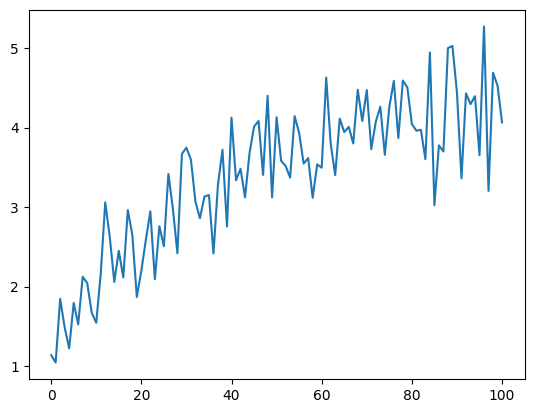

In [35]:
import matplotlib.pyplot as plt
import numpy as np

reward_means = [stat['env/reward_mean'] for stat in all_stats]
plt.plot(reward_means)
plt.show()

## Model inspection
Let's inspect some examples from the IMDB dataset. We can use `ref_model` to compare the tuned model `model` against the model before optimisation.

In [36]:
import pandas as pd

#### get a batch from the dataset
bs = 16
game_data = dict()
ds.set_format("pandas")
df_batch = ds[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "temperature" : 0.8,
    "pad_token_id": tokenizer.eos_token_id,
}

def reward_function(rm_model_output):
    if rm_model_output[0]['score'] > rm_model_output[1]['score']:
        if rm_model_output[0]['label'] == 'POSITIVE':
            return torch.tensor(2*rm_model_output[0]['score'])
        else:
            return torch.tensor(0.5*rm_model_output[0]['score'])

    elif rm_model_output[1]['score'] > rm_model_output[0]['score']:
        if rm_model_output[1]['label'] == 'POSITIVE':
            return torch.tensor(2*rm_model_output[1]['score'])
        else:
            return torch.tensor(0.5*rm_model_output[0]['score'])

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    gen_len = output_length_sampler()
    
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to('cuda'),
        max_new_tokens=gen_len, **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    
    output = sft_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to('cuda'),
        max_new_tokens=gen_len, **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i])
                                      for i in range(bs)]
game_data["response (after)"] = [tokenizer.decode(response_tensors[i])
                                     for i in range(bs)]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"],
                               game_data["response (before)"])]
rm_outputs_before = reward_model(texts,
                          **rm_kwargs)
rewards_before = [reward_function(output).numpy().item()
                    for output in rm_outputs_before]
game_data["rewards (before)"] = rewards_before

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
rm_outputs_after = reward_model(texts,
                          **rm_kwargs)
rewards_after = [reward_function(output).numpy().item()
                    for output in rm_outputs_after]
game_data["rewards (after)"] = rewards_after

# store results in a dataframe
pd.set_option('display.max_colwidth', None)
df_results = pd.DataFrame(game_data)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,I thought,that the point made by the argument was that it was a clever way to,", wow, you're actually funny. That's a great feeling for my",2.477287,4.816433
1,the cover of the,"article.\n\n""First, I'm not going to endorse these ways of life,"" he explains. ""Nobody is saying that they don't exist",current issue of Newsweek's magazine. It's fabulous. It's a great collection. It's brilliant. It's a great way to read at a,-0.073137,5.836455
2,The silent one-,"liner gives the film a subtle message: ""Vote in 2020",step-to-the-I-know-what-,4.183683,3.092249
3,"A series of vignettes,","all shot for the first time, that relate the odyssey of the cartoon characters, which was based on the illustrated book of",well developed and adapted to the tricolour style that I love to do. It will be a great template and blend for,4.044033,5.681169
4,I saw this,"in my parents' house as well. I remember that when I was a kid, I remember",year and it was a great experience. It was a great experience. And I love it.,3.936592,5.809230
5,When I,"started working on the game Aloha in July 2011, I had thought that I would be a pretty cool person. I was very, very","get back, it's a great experience. It's a great feeling. It's a great story. It's a great experience for all",3.851201,5.808207
6,This Raggedy Ann and,Gloria Minter review the fine print of the Labour Party.\n\n12,I will share that story with you.\n\nThank you for doing this,0.589892,3.191509
7,Eric Valette is obviously a talented,"player on the ice, but he's also had to adapt in order to get to","woman, but she is a beautiful girl, and great. It's wonderful to go",0.128715,5.181576
8,The scenes,"of the movie are different, but they're all pretty good from what you see on the Internet. I was sitting in a dark room with a","that took place in spring and summer were very different from the ones that we were trying to create. The sensations that I was getting from it,",3.533607,4.247052
9,Welcome to Collinwood,'s crazy 'rise' and the quick kick @Collinwoodhomes: https://t.co/C8VQtZ,100% at your own pace. It's just what I love!\n\nI just love it! You are very happy you have covered,3.017806,5.506510


Looking at the reward mean/median of the generated sequences we observe a significant difference.

In [37]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

mean:


rewards (before)    2.449415
rewards (after)     4.935010
dtype: float64


median:


rewards (before)    2.747547
rewards (after)     5.444576
dtype: float64

## Save model
Finally, we save the model and push it to the Hugging Face for later usage.

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [38]:
ALIGNED_MODEL_NAME = 'aligned-gpt2-rlhf'

sft_model.save_pretrained(ALIGNED_MODEL_NAME)
tokenizer.save_pretrained(ALIGNED_MODEL_NAME)

('aligned-gpt2-rlhf/tokenizer_config.json',
 'aligned-gpt2-rlhf/special_tokens_map.json',
 'aligned-gpt2-rlhf/vocab.json',
 'aligned-gpt2-rlhf/merges.txt',
 'aligned-gpt2-rlhf/added_tokens.json',
 'aligned-gpt2-rlhf/tokenizer.json')

In [ ]:
# sft_model.push_to_hub('dipanjanS/'+ALIGNED_MODEL_NAME)
# tokenizer.push_to_hub('dipanjanS/'+ALIGNED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dipanjanS/aligned-gpt2-rlhf/commit/b4afe38157228dc89d4c72b407280c77413edd0a', commit_message='Upload tokenizer', commit_description='', oid='b4afe38157228dc89d4c72b407280c77413edd0a', pr_url=None, pr_revision=None, pr_num=None)

In [44]:
reviews = [
    "If I have to review this movie, I would",
    "How could anyone",
    "The makers of this movie don't care",
    "I did not expect this",
    "The thing about this movie which",
    "Here are my 2 cents on the movie",
    "This movie is not a",
    "This is not the",
    "Did not expect this movie"
]

In [41]:
rlhf_model = AutoModelForCausalLMWithValueHead.from_pretrained(ALIGNED_MODEL_NAME,
                                                               device_map='cuda')
aligned_tokenizer = AutoTokenizer.from_pretrained(ALIGNED_MODEL_NAME)


vanilla_model = AutoModelForCausalLMWithValueHead.from_pretrained('openai-community/gpt2',
                                                                  cache_dir='./vanilla',
                                                                  device_map='cuda')
vanilla_tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')

Some weights of the model checkpoint at aligned-gpt2-rlhf were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [42]:
from IPython.display import display, Markdown

In [46]:
for review in reviews:
    inputs = aligned_tokenizer(review, return_tensors="pt",
                               return_token_type_ids=False).to('cuda')
    print("----ALIGNED-MODEL ----")
    outputs = rlhf_model.generate(**inputs,
                                  eos_token_id=aligned_tokenizer.eos_token_id,
                                  pad_token_id=aligned_tokenizer.eos_token_id,
                                  max_new_tokens=32,
                                  temperature=0.8,
                                  do_sample=True)
    display(Markdown((aligned_tokenizer.decode(outputs[0],
                                               skip_special_tokens=True))))
    print("---- NON-ALIGNED-MODEL ----")
    inputs = vanilla_tokenizer(review, return_tensors="pt",
                               return_token_type_ids=False).to('cuda')
    outputs = vanilla_model.generate(**inputs,
                                     eos_token_id=vanilla_tokenizer.eos_token_id,
                                     pad_token_id=vanilla_tokenizer.eos_token_id,
                                     max_new_tokens=32,
                                     temperature=0.8,
                                     do_sample=True)
    display(Markdown((vanilla_tokenizer.decode(outputs[0],
                                               skip_special_tokens=True))))
    print("---- END ----")
    print()

----ALIGNED-MODEL ----


If I have to review this movie, I would like to do it. It's a great movie, so I love it. It is a great story. It is a great story. It is a great

---- NON-ALIGNED-MODEL ----


If I have to review this movie, I would certainly let you know that. It's about a man who's been in love with one love child, having a child at a distance. You see this,

---- END ----

----ALIGNED-MODEL ----


How could anyone understand what's going on there? But luckily, it's all so fun! And I love it. It was a really great experience. And it was a

---- NON-ALIGNED-MODEL ----


How could anyone find out why those women weren't so different from me? It's an incredible story that I hope to tell.

For me, it's not about

---- END ----

----ALIGNED-MODEL ----


The makers of this movie don't care about any of the awards it's produced for, they want to see it for what it is. It is amazing. It's a unique movie that is really

---- NON-ALIGNED-MODEL ----


The makers of this movie don't care about that.

It's not like they won their game. It's not like they've been able to win. It's not like they've gotten

---- END ----

----ALIGNED-MODEL ----


I did not expect this, so I really enjoyed it. It was a great exercise, and I loved the process of it. It was a good afternoon. The team was very helpful

---- NON-ALIGNED-MODEL ----


I did not expect this.

As I entered the room, I felt the heavy metal doors slam shut and the door opened.

"Do you hear me?" I asked

---- END ----

----ALIGNED-MODEL ----


The thing about this movie which I love about it is the story. I like the way it's set up and the way it's it. It's very unique and it's very different

---- NON-ALIGNED-MODEL ----


The thing about this movie which is such a big part of my life, it makes me cry. I want to scream because it's so cool. As opposed to being in some sort of

---- END ----

----ALIGNED-MODEL ----


Here are my 2 cents on the movie. It was wonderful to watch the movie! I love it! It is a great moment for those of us, but I also it was a great movie with

---- NON-ALIGNED-MODEL ----


Here are my 2 cents on the movie:

I don't know if the movie is going to be released, but they definitely have a big fan base and they're definitely going to release it

---- END ----

----ALIGNED-MODEL ----


This movie is not a perfect, great story, but it is very fun. It's a little bit of a mix than I want to be with the theme of it, but I

---- NON-ALIGNED-MODEL ----


This movie is not a comedy. It is not a political thriller. The first thing you do in your novel is to try to talk about what you know about American politics. You have

---- END ----

----ALIGNED-MODEL ----


This is not the best way to handle this, but it's a good way to handle it. It's a great idea, it is a great idea, it's a great

---- NON-ALIGNED-MODEL ----


This is not the first time that Apple has used Apple's APIs to write apps. Back in 2011, Apple introduced what's known as the "Apple Accessibility Framework," a new

---- END ----

----ALIGNED-MODEL ----


Did not expect this movie, but it's the kind of movie I want to see. And I really like it. It's great. It's an incredible movie. I love the

---- NON-ALIGNED-MODEL ----


Did not expect this movie to be as bad as you were expecting. It was so bad."

The film got more buzz than most people imagined. But critics turned to it for

---- END ----



Thus we can see the tuned GPT-2 model has been aligned more to generate positive content overall

In [47]:
# cleanup
!rm -rf aligned-gpt2-rlhf
!rm -rf ref
!rm -rf sft
!rm -rf vanilla